# LoL Churn Predictor [Part 2 - Data Cleaning and EDA]

**David Skarbrevik - 2018**

In part 1 we acquired League of Legends player gameplay data. Now we want to make sure our data is in good shape and perform some basic analysis to see if we can learn anything interesting about our data before we move on to modeling our churn prediction task.

<a id="toc"></a>

<br>
<hr style="background-color: black; padding: 1px;">
<br>

<h2>Table of Contents</h2>

<br>

<ol>
    <h3><li><a href="#section1">Planning</a></li></h3>
    <br>
    <h3><li><a href="#section2">Data cleaning</a></li></h3>
    <br>
    <h3><li><a href="#section3">Exploratory Data Analysis</a></li></h3>
</ol>

<br>
<hr style="background-color: black; padding: 1px;">
<br>

<a id='section1'></a>

## Step 1) Planning

### What kind of cleaning should I look into?

* check for missing data
* check for duplicate data
* make sure data is organized in an easily readable way

### What kind of basic questions would I like to ask of the data?

* Are the players under level 3 losing their first match more than those that get past level 3?
* Do the players under level 3 have a much lower KDA in their first match than those that get past level 3?
* How long is the average game for players at these low levels?

### Best visualizations to summarize this data?

* histogram of summoner level
* Bar charts of a few different stats, grouped by summoner level

### Assumptions / bias of this dataset [very important disclaimer]

While the Riot API theoretically gives access to ALL players of League of Legends, I made very specific restraints on what players would make it to my dataset when I collected my data. 

There were two main constraints:

**1) time constraint:** the player must have had their first match in 2018 and their most recent match (whether first or not) must not be more recent than 1 month before I collected their data.

**2) level constraint:** the player must not have a summoner level above 5.

The upper time constraint exists so that I can ensure that enough time has passed for a player to have "churned" by my definition (1 month of inactivity). And the lower time constraint exists to ensure that all players come from a similar time in the history of League of Legends. This keeps models more relevant to Riot's current situation while also holding many variables, that would confound analysis, a little more constant.

The level cap exists because of the method used to collect data. There is no easy way to get an even distribution of summoner levels, and since I am interested in new players, it is easiest to only collect data from low level players.

However, this means that any analysis of the data must always keep in mind that **this is a very specific sample of League of Legends players and is likely not representative of the population of all players.**

***

<div align="right">
    <a href="#toc">back to top</a>
</div>
<a id='section2'></a>

## Step 2) Data Cleaning

In [1]:
import pandas as pd
import numpy as np
from collections import Counter

In [2]:
# this dataset has over 100 columns so pandas will truncate our results by default
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
# pd.options.mode.chained_assignment = None  # default='warn'

import warnings
warnings.filterwarnings("ignore")

**Import data**

In [17]:
df = pd.read_csv("./data/riot_master_df.csv", encoding="ISO-8859-1")

**Overview of Data**

In [18]:
df.head()

,assists,champLevel,combatPlayerScore,creepsPerMinDeltas_0-10,creepsPerMinDeltas_10-20,creepsPerMinDeltas_20-30,creepsPerMinDeltas_30-end,csDiffPerMinDeltas_0-10,csDiffPerMinDeltas_10-20,csDiffPerMinDeltas_20-30,csDiffPerMinDeltas_30-end,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,damageTakenDiffPerMinDeltas_0-10,damageTakenDiffPerMinDeltas_10-20,damageTakenDiffPerMinDeltas_20-30,damageTakenDiffPerMinDeltas_30-end,damageTakenPerMinDeltas_0-10,damageTakenPerMinDeltas_10-20,damageTakenPerMinDeltas_20-30,damageTakenPerMinDeltas_30-end,deaths,doubleKills,firstBloodAssist,firstBloodKill,firstInhibitorAssist,firstInhibitorKill,firstTowerAssist,firstTowerKill,first_match_duration,first_match_id,first_match_time,goldEarned,goldPerMinDeltas_0-10,goldPerMinDeltas_10-20,goldPerMinDeltas_20-30,goldPerMinDeltas_30-end,goldSpent,id,inhibitorKills,item0,item1,item2,item3,item4,item5,item6,killingSprees,kills,lane,largestCriticalStrike,largestKillingSpree,largestMultiKill,latest_match_time,longestTimeSpentLiving,magicDamageDealt,magicDamageDealtToChampions,magicalDamageTaken,neutralMinionsKilled,neutralMinionsKilledEnemyJungle,neutralMinionsKilledTeamJungle,objectivePlayerScore,participantId,pentaKills,perkPrimaryStyle,perkSubStyle,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,playerScore0,playerScore1,playerScore2,playerScore3,playerScore4,playerScore5,playerScore6,playerScore7,playerScore8,playerScore9,quadraKills,role,sightWardsBoughtInGame,summoner_id,summoner_level,summoner_name,timeCCingOthers,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,totalHeal,totalMinionsKilled,totalPlayerScore,totalScoreRank,totalTimeCrowdControlDealt,totalUnitsHealed,total_matches,tripleKills,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,xpDiffPerMinDeltas_0-10,xpDiffPerMinDeltas_10-20,xpDiffPerMinDeltas_20-30,xpDiffPerMinDeltas_30-end,xpPerMinDeltas_0-10,xpPerMinDeltas_10-20,xpPerMinDeltas_20-30,xpPerMinDeltas_30-end
0,16.0,12.0,0.0,5.1,0.0,0.0,0.0,4.80,0.0,0.0,0.0,4624.0,4624.0,4268.0,-205.3,0.0,0.0,0.0,388.2,0.0,0.0,0.0,0.0,0.0,False,False,True,False,False,False,0 days 00:14:00.000000000,2695060245,2018-01-16T05:50:54.986000+00:00,8012.0,496.3,0.0,0.0,0.0,2850.0,4.0,0.0,1054.0,3044.0,3067.0,1001.0,0.0,0.0,3340.0,1.0,13.0,MIDDLE,456.0,13.0,1.0,2018-01-17T06:05:14.227000+00:00,0.0,3005.0,2392.0,1005.0,0.0,0.0,0.0,0.0,4.0,0.0,8400.0,8200.0,48136.0,11330.0,7246.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SOLO,0.0,92201075,5,TrEx18,18.0,51142.0,13723.0,8252.0,1128.0,63.0,0.0,0.0,274.0,1.0,7,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,True,371.20,0.0,0.0,0.0,583.9,0.0,0.0,0.0
1,4.0,11.0,0.0,3.5,0.0,0.0,0.0,1.72,0.0,0.0,0.0,1885.0,1885.0,5206.0,-200.0,0.0,0.0,0.0,478.0,0.0,0.0,0.0,2.0,3.0,False,False,False,False,False,False,0 days 00:16:41.000000000,2736710108,2018-03-10T06:24:33.477000+00:00,9014.0,318.3,0.0,0.0,0.0,8850.0,2.0,0.0,3142.0,3147.0,3111.0,1043.0,1036.0,1055.0,3340.0,2.0,13.0,NONE,0.0,9.0,2.0,2018-03-10T14:58:21.007000+00:00,654.0,968.0,888.0,3374.0,4.0,4.0,0.0,0.0,2.0,0.0,8100.0,8000.0,46817.0,12594.0,7109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DUO_SUPPORT,0.0,93650017,5,iMain N01,59.0,52490.0,13817.0,11503.0,3662.0,58.0,0.0,0.0,123.0,1.0,6,0.0,4704.0,334.0,1019.0,0.0,0.0,3.0,0.0,0.0,3.0,True,84.66,0.0,0.0,0.0,363.9,0.0,0.0,0.0
2,10.0,13.0,0.0,0.8,3.6,0.0,0.0,NaN,NaN,NaN,NaN,6838.0,5972.0,11147.0,NaN,NaN,NaN,NaN,564.3,862.1,0.0,0.0,2.0,0.0,False,False,True,False,False,False,0 days 00:22:54.000000000,2736716714,2018-03-10T06:56:11.750000+00:00,10869.0,353.0,412.7,0.0,0.0,6800.0,2.0,0.0,2003.0,1055.0,3133.0,3071.0,3076.0,3086.0,3340.0,3.0,10.0,JUNGLE,499.0,5.0,1.0,2018-03-21T08:32:17.048000+00:00,419.0,1229.0,288.0,2291.0,16.0,0.0,13.0,0.0,2.0,0.0,8100.0,8000.0,67383.0,10907.0,14573.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NONE,0.0,92729877,5,luexolu99,36.0,70890.0,11789.0,16942.0,879

In [19]:
df.shape

(1598, 116)

**Is there missing data?**

In [20]:
if df[df.isnull().any(axis=1)].empty:
    print("No missing values!")
else:
    print("Missing data from {} rows".format(df[df.isnull().any(axis=1)].shape[0]))

Missing data from 462 rows


**What columns are missing data?**

In [21]:
df.isnull().sum()

assists                                 1
champLevel                              1
combatPlayerScore                       1
creepsPerMinDeltas_0-10                 5
creepsPerMinDeltas_10-20                5
creepsPerMinDeltas_20-30                5
creepsPerMinDeltas_30-end               5
csDiffPerMinDeltas_0-10               446
csDiffPerMinDeltas_10-20              446
csDiffPerMinDeltas_20-30              446
csDiffPerMinDeltas_30-end             446
damageDealtToObjectives                 1
damageDealtToTurrets                    1
damageSelfMitigated                     1
damageTakenDiffPerMinDeltas_0-10      446
damageTakenDiffPerMinDeltas_10-20     446
damageTakenDiffPerMinDeltas_20-30     446
damageTakenDiffPerMinDeltas_30-end    446
damageTakenPerMinDeltas_0-10            5
damageTakenPerMinDeltas_10-20           5
damageTakenPerMinDeltas_20-30           5
damageTakenPerMinDeltas_30-end          5
deaths                                  1
doubleKills                       

**Dealing with the missing data**

We see that a lot of the columns are only missing 1 data point, this could be from a single player. Let's take a look:

In [22]:
df.loc[df['assists'].isnull()]

,assists,champLevel,combatPlayerScore,creepsPerMinDeltas_0-10,creepsPerMinDeltas_10-20,creepsPerMinDeltas_20-30,creepsPerMinDeltas_30-end,csDiffPerMinDeltas_0-10,csDiffPerMinDeltas_10-20,csDiffPerMinDeltas_20-30,csDiffPerMinDeltas_30-end,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,damageTakenDiffPerMinDeltas_0-10,damageTakenDiffPerMinDeltas_10-20,damageTakenDiffPerMinDeltas_20-30,damageTakenDiffPerMinDeltas_30-end,damageTakenPerMinDeltas_0-10,damageTakenPerMinDeltas_10-20,damageTakenPerMinDeltas_20-30,damageTakenPerMinDeltas_30-end,deaths,doubleKills,firstBloodAssist,firstBloodKill,firstInhibitorAssist,firstInhibitorKill,firstTowerAssist,firstTowerKill,first_match_duration,first_match_id,first_match_time,goldEarned,goldPerMinDeltas_0-10,goldPerMinDeltas_10-20,goldPerMinDeltas_20-30,goldPerMinDeltas_30-end,goldSpent,id,inhibitorKills,item0,item1,item2,item3,item4,item5,item6,killingSprees,kills,lane,largestCriticalStrike,largestKillingSpree,largestMultiKill,latest_match_time,longestTimeSpentLiving,magicDamageDealt,magicDamageDealtToChampions,magicalDamageTaken,neutralMinionsKilled,neutralMinionsKilledEnemyJungle,neutralMinionsKilledTeamJungle,objectivePlayerScore,participantId,pentaKills,perkPrimaryStyle,perkSubStyle,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,playerScore0,playerScore1,playerScore2,playerScore3,playerScore4,playerScore5,playerScore6,playerScore7,playerScore8,playerScore9,quadraKills,role,sightWardsBoughtInGame,summoner_id,summoner_level,summoner_name,timeCCingOthers,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,totalHeal,totalMinionsKilled,totalPlayerScore,totalScoreRank,totalTimeCrowdControlDealt,totalUnitsHealed,total_matches,tripleKills,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,xpDiffPerMinDeltas_0-10,xpDiffPerMinDeltas_10-20,xpDiffPerMinDeltas_20-30,xpDiffPerMinDeltas_30-end,xpPerMinDeltas_0-10,xpPerMinDeltas_10-20,xpPerMinDeltas_20-30,xpPerMinDeltas_30-end
982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:28,2717262656,2018-02-12T21:53:43.622000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TOP,NaN,NaN,NaN,2018-02-15T18:09:10.473000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DUO,NaN,92790619,3,ChiefShonah,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Perhaps this player left his first game right as it started? Though if that is the reason, it's amazing there aren't at least a few more cases in our dataset like this. 

Let's see what the NaN column counts look like after we remove this player.

In [23]:
df = df.drop(df.index[982]) # drop one specific player

In [24]:
df.isnull().sum()

assists                                 0
champLevel                              0
combatPlayerScore                       0
creepsPerMinDeltas_0-10                 4
creepsPerMinDeltas_10-20                4
creepsPerMinDeltas_20-30                4
creepsPerMinDeltas_30-end               4
csDiffPerMinDeltas_0-10               445
csDiffPerMinDeltas_10-20              445
csDiffPerMinDeltas_20-30              445
csDiffPerMinDeltas_30-end             445
damageDealtToObjectives                 0
damageDealtToTurrets                    0
damageSelfMitigated                     0
damageTakenDiffPerMinDeltas_0-10      445
damageTakenDiffPerMinDeltas_10-20     445
damageTakenDiffPerMinDeltas_20-30     445
damageTakenDiffPerMinDeltas_30-end    445
damageTakenPerMinDeltas_0-10            4
damageTakenPerMinDeltas_10-20           4
damageTakenPerMinDeltas_20-30           4
damageTakenPerMinDeltas_30-end          4
deaths                                  0
doubleKills                       

OK, most of the columns don't have NaNs now, but a lot have exactly 4 or 445 missing values. These are all features with a time component, so it is likely that these games just didn't go long enough to produce values. However, because the 0-10min category also has 445 missing values it's possible that these are all players that dropped their first game shortly after joining the match. It should be appropriate to set those columns to 0.

But let's see what the data for these players looks like before we do that:

In [25]:
df.loc[df['xpDiffPerMinDeltas_0-10'].isnull()].head(n=10) # just choosing one of the time features, doesn't matter

,assists,champLevel,combatPlayerScore,creepsPerMinDeltas_0-10,creepsPerMinDeltas_10-20,creepsPerMinDeltas_20-30,creepsPerMinDeltas_30-end,csDiffPerMinDeltas_0-10,csDiffPerMinDeltas_10-20,csDiffPerMinDeltas_20-30,csDiffPerMinDeltas_30-end,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,damageTakenDiffPerMinDeltas_0-10,damageTakenDiffPerMinDeltas_10-20,damageTakenDiffPerMinDeltas_20-30,damageTakenDiffPerMinDeltas_30-end,damageTakenPerMinDeltas_0-10,damageTakenPerMinDeltas_10-20,damageTakenPerMinDeltas_20-30,damageTakenPerMinDeltas_30-end,deaths,doubleKills,firstBloodAssist,firstBloodKill,firstInhibitorAssist,firstInhibitorKill,firstTowerAssist,firstTowerKill,first_match_duration,first_match_id,first_match_time,goldEarned,goldPerMinDeltas_0-10,goldPerMinDeltas_10-20,goldPerMinDeltas_20-30,goldPerMinDeltas_30-end,goldSpent,id,inhibitorKills,item0,item1,item2,item3,item4,item5,item6,killingSprees,kills,lane,largestCriticalStrike,largestKillingSpree,largestMultiKill,latest_match_time,longestTimeSpentLiving,magicDamageDealt,magicDamageDealtToChampions,magicalDamageTaken,neutralMinionsKilled,neutralMinionsKilledEnemyJungle,neutralMinionsKilledTeamJungle,objectivePlayerScore,participantId,pentaKills,perkPrimaryStyle,perkSubStyle,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,playerScore0,playerScore1,playerScore2,playerScore3,playerScore4,playerScore5,playerScore6,playerScore7,playerScore8,playerScore9,quadraKills,role,sightWardsBoughtInGame,summoner_id,summoner_level,summoner_name,timeCCingOthers,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,totalHeal,totalMinionsKilled,totalPlayerScore,totalScoreRank,totalTimeCrowdControlDealt,totalUnitsHealed,total_matches,tripleKills,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,xpDiffPerMinDeltas_0-10,xpDiffPerMinDeltas_10-20,xpDiffPerMinDeltas_20-30,xpDiffPerMinDeltas_30-end,xpPerMinDeltas_0-10,xpPerMinDeltas_10-20,xpPerMinDeltas_20-30,xpPerMinDeltas_30-end
2,10.0,13.0,0.0,0.8,3.6,0.0,0.0,NaN,NaN,NaN,NaN,6838.0,5972.0,11147.0,NaN,NaN,NaN,NaN,564.3,862.1,0.0,0.0,2.0,0.0,False,False,True,False,False,False,0 days 00:22:54.000000000,2736716714,2018-03-10T06:56:11.750000+00:00,10869.0,353.0,412.7,0.0,0.0,6800.0,2.0,0.0,2003.0,1055.0,3133.0,3071.0,3076.0,3086.0,3340.0,3.0,10.0,JUNGLE,499.0,5.0,1.0,2018-03-21T08:32:17.048000+00:00,419.0,1229.0,288.0,2291.0,16.0,0.0,13.0,0.0,2.0,0.0,8100.0,8000.0,67383.0,10907.0,14573.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NONE,0.0,92729877,5,luexolu99,36.0,70890.0,11789.0,16942.0,8791.0,50.0,0.0,0.0,145.0,1.0,4,0.0,2277.0,593.0,77.0,2.0,0.0,0.0,0.0,0.0,0.0,True,NaN,NaN,NaN,NaN,331.8,464.2,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,0 days 00:28:54.000000000,2736217337,2018-03-09T13:05:59.377000+00:00,5089.0,100.0,164.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOP,0.0,0.0,0.0,2018-03-09T13:05:59.377000+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,8400.0,8200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DUO_SUPPORT,0.0,93839689,1,Md95359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
5,7.0,15.0,0.0,3.5,5.4,0.0,0.0,NaN,NaN,NaN,NaN,2130.0,2130.0,16903.0,NaN,NaN,NaN,NaN,321.5,740.3,0.0,0.0,5.0,3.0,False,False,True,False,False,False,0 days 00:26:05.000000000,2741305286,2018-03-16T20:15:31.237000+00:00,12784.0,386.4,518.8,0.0,0.0,12200.0,5.0,0.0,3072.0,3046.0,1029.0,3006.0,3031.0,0.0,3340.0,3.0,14.0,MIDDLE,665.0,7.0,2.0,2018-03-18T07:38:08.817000+00:00,780.0,6271.0,704.0,6075.0,12.0,8.0,4.0,0.0,5.0,0.0,8000.0,8200.0,106662.0,30303.0,11636.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DUO,0.0,93782084,5,Häsagi,40.0,112934.0,31008.0,18013.0,1967.0,109.0,0.0,0.0,110.0,1.0,6,0.0,0.0,0.0,301.0,1.0,0.0,0.0,0.0,0.0,0.0,True,Na

It appears that the these players actually did play their first match through, there was just an issue collecting the "timeline" data. 

**Possible solutions:**

**1) set all timeline NaNs to 0**

2) drop all timeline data from dataset

3) take summoner ids that have NaNs and re-mine their data to see if I can get it

**I'm going to try option 1**, but ultimately I'll want to take the time to do option 3 to reduce noise in my data and models.

In [26]:
time_columns = [i for i,x in enumerate(df.isnull().sum().tolist()) if x == 445 or x == 4] # columns with missing time data
time_cols = list(df.iloc[:, time_columns])
values = {col:0 for col in time_cols}
df = df.fillna(value = values)

In [27]:
df.isnull().sum()

assists                                0
champLevel                             0
combatPlayerScore                      0
creepsPerMinDeltas_0-10                0
creepsPerMinDeltas_10-20               0
creepsPerMinDeltas_20-30               0
creepsPerMinDeltas_30-end              0
csDiffPerMinDeltas_0-10                0
csDiffPerMinDeltas_10-20               0
csDiffPerMinDeltas_20-30               0
csDiffPerMinDeltas_30-end              0
damageDealtToObjectives                0
damageDealtToTurrets                   0
damageSelfMitigated                    0
damageTakenDiffPerMinDeltas_0-10       0
damageTakenDiffPerMinDeltas_10-20      0
damageTakenDiffPerMinDeltas_20-30      0
damageTakenDiffPerMinDeltas_30-end     0
damageTakenPerMinDeltas_0-10           0
damageTakenPerMinDeltas_10-20          0
damageTakenPerMinDeltas_20-30          0
damageTakenPerMinDeltas_30-end         0
deaths                                 0
doubleKills                            0
firstBloodAssist

OK now there are a few more features with NaNs. 

Let's look at "perkSubStyle":

In [28]:
df.loc[df['perkSubStyle'].isnull()].head(n=10)

,assists,champLevel,combatPlayerScore,creepsPerMinDeltas_0-10,creepsPerMinDeltas_10-20,creepsPerMinDeltas_20-30,creepsPerMinDeltas_30-end,csDiffPerMinDeltas_0-10,csDiffPerMinDeltas_10-20,csDiffPerMinDeltas_20-30,csDiffPerMinDeltas_30-end,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,damageTakenDiffPerMinDeltas_0-10,damageTakenDiffPerMinDeltas_10-20,damageTakenDiffPerMinDeltas_20-30,damageTakenDiffPerMinDeltas_30-end,damageTakenPerMinDeltas_0-10,damageTakenPerMinDeltas_10-20,damageTakenPerMinDeltas_20-30,damageTakenPerMinDeltas_30-end,deaths,doubleKills,firstBloodAssist,firstBloodKill,firstInhibitorAssist,firstInhibitorKill,firstTowerAssist,firstTowerKill,first_match_duration,first_match_id,first_match_time,goldEarned,goldPerMinDeltas_0-10,goldPerMinDeltas_10-20,goldPerMinDeltas_20-30,goldPerMinDeltas_30-end,goldSpent,id,inhibitorKills,item0,item1,item2,item3,item4,item5,item6,killingSprees,kills,lane,largestCriticalStrike,largestKillingSpree,largestMultiKill,latest_match_time,longestTimeSpentLiving,magicDamageDealt,magicDamageDealtToChampions,magicalDamageTaken,neutralMinionsKilled,neutralMinionsKilledEnemyJungle,neutralMinionsKilledTeamJungle,objectivePlayerScore,participantId,pentaKills,perkPrimaryStyle,perkSubStyle,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,playerScore0,playerScore1,playerScore2,playerScore3,playerScore4,playerScore5,playerScore6,playerScore7,playerScore8,playerScore9,quadraKills,role,sightWardsBoughtInGame,summoner_id,summoner_level,summoner_name,timeCCingOthers,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,totalHeal,totalMinionsKilled,totalPlayerScore,totalScoreRank,totalTimeCrowdControlDealt,totalUnitsHealed,total_matches,tripleKills,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,xpDiffPerMinDeltas_0-10,xpDiffPerMinDeltas_10-20,xpDiffPerMinDeltas_20-30,xpDiffPerMinDeltas_30-end,xpPerMinDeltas_0-10,xpPerMinDeltas_10-20,xpPerMinDeltas_20-30,xpPerMinDeltas_30-end
226,3.0,9.0,0.0,0.3,0.0,0.0,0.0,1.44,0.00,0.0,0.0,3619.0,3619.0,5428.0,-36.42,0.00,0.0,0.0,415.5,0.0,0.0,0.0,6.0,0.0,False,False,False,False,False,False,0 days 00:19:04.000000000,2736312050,2018-03-09T20:23:32.929000+00:00,6213.0,171.3,0.0,0.0,0.0,1250.0,5.0,0.0,1056.0,1026.0,0.0,0.0,0.0,0.0,3341.0,0.0,1.0,NONE,0.0,0.0,1.0,2018-03-17T17:44:56.142000+00:00,251.0,9006.0,1256.0,2489.0,0.0,0.0,0.0,0.0,5.0,0.0,8200.0,NaN,7273.0,854.0,5197.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DUO_SUPPORT,0.0,93689587,5,spicyemperor908,0.0,23342.0,2782.0,7687.0,1359.0,20.0,0.0,0.0,15.0,3.0,9,0.0,7062.0,672.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,True,83.02,0.0,0.0,0.0,153.9,0.0,0.0,0.0
269,4.0,14.0,0.0,3.4,2.2,0.0,0.0,0.00,0.00,0.0,0.0,3245.0,3245.0,11722.0,0.00,0.00,0.0,0.0,139.1,706.7,0.0,0.0,0.0,0.0,False,False,False,False,False,True,0 days 00:29:06.000000000,2736833894,2018-03-10T14:20:37.391000+00:00,12213.0,336.0,364.7,0.0,0.0,5300.0,2.0,0.0,1054.0,1054.0,3044.0,3111.0,3067.0,3044.0,3340.0,1.0,16.0,MIDDLE,0.0,16.0,1.0,2018-03-11T03:25:16.314000+00:00,0.0,7765.0,4105.0,5165.0,2.0,2.0,0.0,0.0,2.0,0.0,8400.0,NaN,55694.0,14893.0,9645.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DUO_CARRY,0.0,93879843,5,GregJuan,20.0,67435.0,18999.0,14810.0,1486.0,74.0,0.0,0.0,157.0,1.0,5,0.0,3975.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,True,0.00,0.0,0.0,0.0,516.9,320.8,0.0,0.0
272,15.0,7.0,0.0,0.4,0.0,0.0,0.0,0.94,0.00,0.0,0.0,862.0,862.0,2395.0,-385.64,0.00,0.0,0.0,338.9,0.0,0.0,0.0,4.0,0.0,False,False,True,False,True,False,0 days 00:12:28.000000000,2743505380,2018-03-19T05:31:31.571000+00:00,4463.0,299.7,0.0,0.0,0.0,3150.0,2.0,0.0,3111.0,3044.0,3067.0,0.0,0.0,0.0,3340.0,1.0,3.0,NONE,0.0,2.0,1.0,2018-03-19T06:07:50.345000+00:00,242.0,611.0,443.0,249.0,0.0,0.0,0.0,0.0,2.0,0.0,8400.0,NaN,9466.0,2954.0,4761.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DUO_SUPPORT,0.0,27808934,4,DeathOni,5.0,12818.0,3397.0,5011.0,65.0,7.0,0.0,0.0,65.0

What are some normal values for this feature?

In [29]:
Counter(df['perkSubStyle'])

Counter({8000.0: 234,
         8100.0: 504,
         8200.0: 843,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1})

I'm not sure what this feature describes, but because not all players have just one value, this may be a useful feature. Because only a small percent of players are missing this value, I am simply going to remove those players from the dataset.

In [30]:
perksub_nan = list(df.loc[df['perkSubStyle'].isnull()].index.values)
df = df.drop(perksub_nan)

Now let's look at the last 4 features with NaN values:

In [31]:
features_with_nan = ["firstInhibitorAssist", "firstInhibitorKill", "firstTowerAssist", "firstTowerKill"]

for feature in features_with_nan:
    print("Feature name: {}".format(feature))
    print(Counter(df[feature]))
    print("\n")

Feature name: firstInhibitorAssist
Counter({False: 1274, True: 302, nan: 5})


Feature name: firstInhibitorKill
Counter({False: 1388, True: 188, nan: 5})


Feature name: firstTowerAssist
Counter({False: 1389, True: 191, nan: 1})


Feature name: firstTowerKill
Counter({False: 1379, True: 201, nan: 1})




As with the 'perkSubStyle' feature there are only a few players with NaN values in the features above. I don't want to randomly assign True or False to these players so I will simply drop them.

In [32]:
nan_index = sum([list(df.loc[df[feature].isnull()].index.values) for feature in features_with_nan], [])
df = df.drop(nan_index)

Let's make sure we don't have any more NaN values:

In [33]:
if df[df.isnull().any(axis=1)].empty:
    print("No missing values!")
else:
    print("Missing data from {} rows".format(df[df.isnull().any(axis=1)].shape[0]))

No missing values!


**Dealing with duplicate rows**

In [34]:
print("Number of duplicate rows in dataset: {}".format(Counter(df.duplicated())[True]))

Number of duplicate rows in dataset: 81


In [35]:
old_rows = df.shape[0]

df = df.drop_duplicates()

new_rows = df.shape[0]

diff = old_rows - new_rows

print("Number of rows removed: {}".format(diff))

Number of rows removed: 81


Good, the number of rows we removed equals the number of duplicate rows so that's a good sign! Ideally there would have been 0 duplicate rows, because I have a check in my data collection functions to try and avoid this. But for now we'll just remove our duplicates.

Now let's rearrange some of the features that tell us about a player but won't be useful in training our model. This will make this a more interesting "at first glance" dataset.

In [36]:
columns = list(df)
front_features = ['summoner_id', 'summoner_name', 'summoner_level', 'total_matches',
                  'first_match_time', 'first_match_duration', 'first_match_id']

In [37]:
len(columns)

116

In [38]:
cols_reordered = [item for item in columns if item not in front_features]
cols_reordered = front_features + cols_reordered

In [39]:
df = df[cols_reordered]

In [40]:
df.head()

,summoner_id,summoner_name,summoner_level,total_matches,first_match_time,first_match_duration,first_match_id,assists,champLevel,combatPlayerScore,creepsPerMinDeltas_0-10,creepsPerMinDeltas_10-20,creepsPerMinDeltas_20-30,creepsPerMinDeltas_30-end,csDiffPerMinDeltas_0-10,csDiffPerMinDeltas_10-20,csDiffPerMinDeltas_20-30,csDiffPerMinDeltas_30-end,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,damageTakenDiffPerMinDeltas_0-10,damageTakenDiffPerMinDeltas_10-20,damageTakenDiffPerMinDeltas_20-30,damageTakenDiffPerMinDeltas_30-end,damageTakenPerMinDeltas_0-10,damageTakenPerMinDeltas_10-20,damageTakenPerMinDeltas_20-30,damageTakenPerMinDeltas_30-end,deaths,doubleKills,firstBloodAssist,firstBloodKill,firstInhibitorAssist,firstInhibitorKill,firstTowerAssist,firstTowerKill,goldEarned,goldPerMinDeltas_0-10,goldPerMinDeltas_10-20,goldPerMinDeltas_20-30,goldPerMinDeltas_30-end,goldSpent,id,inhibitorKills,item0,item1,item2,item3,item4,item5,item6,killingSprees,kills,lane,largestCriticalStrike,largestKillingSpree,largestMultiKill,latest_match_time,longestTimeSpentLiving,magicDamageDealt,magicDamageDealtToChampions,magicalDamageTaken,neutralMinionsKilled,neutralMinionsKilledEnemyJungle,neutralMinionsKilledTeamJungle,objectivePlayerScore,participantId,pentaKills,perkPrimaryStyle,perkSubStyle,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,playerScore0,playerScore1,playerScore2,playerScore3,playerScore4,playerScore5,playerScore6,playerScore7,playerScore8,playerScore9,quadraKills,role,sightWardsBoughtInGame,timeCCingOthers,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,totalHeal,totalMinionsKilled,totalPlayerScore,totalScoreRank,totalTimeCrowdControlDealt,totalUnitsHealed,tripleKills,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,xpDiffPerMinDeltas_0-10,xpDiffPerMinDeltas_10-20,xpDiffPerMinDeltas_20-30,xpDiffPerMinDeltas_30-end,xpPerMinDeltas_0-10,xpPerMinDeltas_10-20,xpPerMinDeltas_20-30,xpPerMinDeltas_30-end
0,92201075,TrEx18,5,7,2018-01-16T05:50:54.986000+00:00,0 days 00:14:00.000000000,2695060245,16.0,12.0,0.0,5.1,0.0,0.0,0.0,4.80,0.0,0.0,0.0,4624.0,4624.0,4268.0,-205.3,0.0,0.0,0.0,388.2,0.0,0.0,0.0,0.0,0.0,False,False,True,False,False,False,8012.0,496.3,0.0,0.0,0.0,2850.0,4.0,0.0,1054.0,3044.0,3067.0,1001.0,0.0,0.0,3340.0,1.0,13.0,MIDDLE,456.0,13.0,1.0,2018-01-17T06:05:14.227000+00:00,0.0,3005.0,2392.0,1005.0,0.0,0.0,0.0,0.0,4.0,0.0,8400.0,8200.0,48136.0,11330.0,7246.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SOLO,0.0,18.0,51142.0,13723.0,8252.0,1128.0,63.0,0.0,0.0,274.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,True,371.20,0.0,0.0,0.0,583.9,0.0,0.0,0.0
1,93650017,iMain N01,5,6,2018-03-10T06:24:33.477000+00:00,0 days 00:16:41.000000000,2736710108,4.0,11.0,0.0,3.5,0.0,0.0,0.0,1.72,0.0,0.0,0.0,1885.0,1885.0,5206.0,-200.0,0.0,0.0,0.0,478.0,0.0,0.0,0.0,2.0,3.0,False,False,False,False,False,False,9014.0,318.3,0.0,0.0,0.0,8850.0,2.0,0.0,3142.0,3147.0,3111.0,1043.0,1036.0,1055.0,3340.0,2.0,13.0,NONE,0.0,9.0,2.0,2018-03-10T14:58:21.007000+00:00,654.0,968.0,888.0,3374.0,4.0,4.0,0.0,0.0,2.0,0.0,8100.0,8000.0,46817.0,12594.0,7109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DUO_SUPPORT,0.0,59.0,52490.0,13817.0,11503.0,3662.0,58.0,0.0,0.0,123.0,1.0,0.0,4704.0,334.0,1019.0,0.0,0.0,3.0,0.0,0.0,3.0,True,84.66,0.0,0.0,0.0,363.9,0.0,0.0,0.0
2,92729877,luexolu99,5,4,2018-03-10T06:56:11.750000+00:00,0 days 00:22:54.000000000,2736716714,10.0,13.0,0.0,0.8,3.6,0.0,0.0,0.00,0.0,0.0,0.0,6838.0,5972.0,11147.0,0.0,0.0,0.0,0.0,564.3,862.1,0.0,0.0,2.0,0.0,False,False,True,False,False,False,10869.0,353.0,412.7,0.0,0.0,6800.0,2.0,0.0,2003.0,1055.0,3133.0,3071.0,3076.0,3086.0,3340.0,3.0,10.0,JUNGLE,499.0,5.0,1.0,2018-03-21T08:32:17.048000+00:00,419.0,1229.0,288.0,2291.0,16.0,0.0,13.0,0.0,2.0,0.0,8100.0,8000.0,67383.0,10907.0,14573.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NONE,0.0,36.0,70890.0,11789.0,16942.0,

Lastly, let's save this dataset as a "cleaned_riot_data.csv" file for future use.

In [41]:
df.to_csv("./data/cleaned_riot_data.csv", index=False)

***

<div align="right">
    <a href="#toc">back to top</a>
</div>
<a id='section3'></a>

## Step 3) Exploratory Data Analysis

In [3]:
import pandas as pd
import numpy as np
from collections import Counter
from scipy import stats, integrate
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import arrow
import datetime


%matplotlib inline

In [4]:
df = pd.read_csv("./data/cleaned_riot_data.csv", encoding="ISO-8859-1")

**Let's better understand the summoner levels of players in our dataset since this is the key feature that we will likely want to predict on later.**

Average summoner level = 3.47


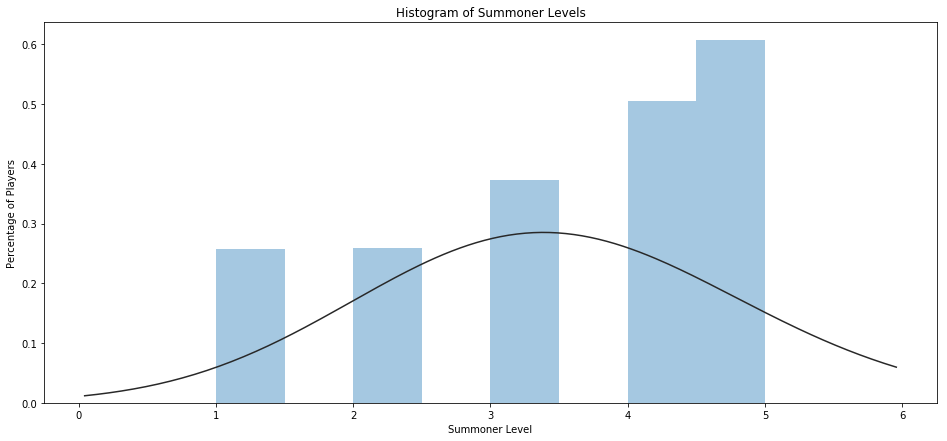

In [62]:
plt.figure(figsize=(16,7))
hist = sns.distplot(df['summoner_level'], kde=False, fit=stats.gamma)
hist.set(title="Histogram of Summoner Levels", xlabel="Summoner Level", ylabel="Percentage of Players")
print("Average summoner level = {:.2f}".format(np.mean(df.summoner_level)))

Of course we see that players are only levels 1-5 as we required during the data collection phase. Most are level 4 or 5 as an artifact of the collection process but a fair amount are still levels 1-3 so there should be enough examples of these low level players to train a decent model.

**Now let's see the timeline range for the match history of players in the dataset.**

[Text(0,0.5,'Number of Players'),
 Text(0.5,0,"Date of Player's First Match"),
 Text(0.5,1,"Time of Player's First Match")]

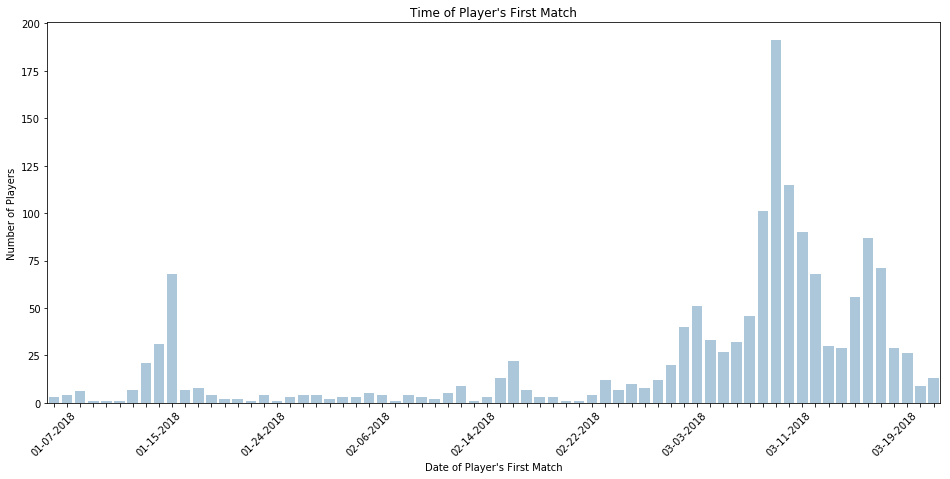

In [5]:
# create time dataframe
years = [arrow.get(x).format('MM-DD-YYYY') for x in df['first_match_time']]
df_match_creation = pd.DataFrame.from_dict(Counter(years), orient='index').reset_index()
df_match_creation = df_match_creation.rename(columns={'index':'time', 0:'count'})
df_match_creation = df_match_creation.sort_values(by="time")

# plot time dataframe as bar plot
#pal = sns.color_palette("Blues_d", len(df_match_creation))
plt.figure(figsize=(16,7))
ax = sns.barplot(x='time', y='count', data=df_match_creation, color="#a5c8e1")

[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % 8 != 0]
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set(title="Time of Player's First Match", xlabel="Date of Player's First Match", ylabel="Number of Players")

We see all players began playing in 2018 and most in early to mid May. This fits the time constraint we made during data collection. Seeing this distribution, we may want to consider trimming off players that began playing before May as this may just bring noise to our model.

<br>

**Now let's consider what in game behaviors may differentiate a player that doesn't end up finishing their tutorial matches:**

Here are a few handpicked stats that I believe may be important:

* Win/Loss
* KDA (kills, deaths, assists)
* Match duration
* Gold earned
* Total minions killed
* Total damage dealt

**Win/Loss rates**

In [6]:
low_level = df[df['summoner_level'] < 3]
high_level = df[df['summoner_level'] >= 3]

print("Win rate of players level 1-2 (n = {0}) = {1:.2f}%".format(low_level.shape[0],(np.sum(low_level['win'])/len(low_level))*100))
print("Win rate of players level 3-5 (n = {0}) = {1:.2f}%".format(high_level.shape[0],(np.sum(high_level['win'])/len(high_level))*100))
print("Two-sided t-test (low_level wins vs high_level wins): p-value = {:.2f}".format(stats.ttest_ind(low_level['win'],high_level['win'])[1]))

Win rate of players level 1-2 (n = 386) = 96.89%
Win rate of players level 3-5 (n = 1109) = 95.67%
Two-sided t-test (low_level wins vs high_level wins): p-value = 0.29


As we can see there isn't much difference between the win rates of these players. It's worth noting that whether a player abandons the game or not, they most likely won their first match. So most likely the issue with a player not continuing to play isn't from an immediately negative experience (giant red DEFEAT screen). Let's look into KDA next.

**KDA**

$KDA = \cfrac{Kills + Assists}{Deaths}$

Note: if deaths = 0 for a player, I still set it to 1 to avoid division by 0.

In [128]:
low_level.loc[low_level['deaths'] == 0, 'deaths'] = 0

In [76]:
low_level.loc[low_level['deaths'] == 0, 'deaths'] = 1
high_level.loc[high_level['deaths'] == 0, 'deaths'] = 1

low_level.KDA = (low_level.kills + low_level.assists)/(low_level.deaths)
high_level.KDA = (high_level.kills + high_level.assists)/(high_level.deaths)

print("Average KDA of players level 1-2 (n = {0}) = {1:.2f}".format(low_level.shape[0],np.mean(low_level.KDA)))
print("Average KDA of players level 3-5 (n = {0}) = {1:.2f}".format(high_level.shape[0],np.mean(high_level.KDA)))
print("Two-sided t-test (low_level player KDA vs high_level player KDA): p-value = {:.5f}".format(stats.ttest_ind(low_level.KDA,high_level.KDA)[1]))

Average KDA of players level 1-2 (n = 386) = 6.00
Average KDA of players level 3-5 (n = 1109) = 8.49
Two-sided t-test (low_level player KDA vs high_level player KDA): p-value = 0.00001


While not a huge difference, as we might expect, players that stick around longer tend to be those that are performing a little better in these key ways. Next, let's consider how the average duration of a first match changes for these player levels.

**Average match duration**

In [268]:
low_level_times = [str(arrow.get(value, 'hh:mm:ss').time()) for value in low_level['first_match_duration']]
high_level_times = [str(arrow.get(value, 'hh:mm:ss').time()) for value in high_level['first_match_duration']]

In [272]:
# not good practice, but this two-for-one function either gives a single datetime.time object or a list of ints
def average_int_time(list_of_times, return_int_times=False):
    
    times_as_int = []
    
    for time in list_of_times:
        time_split = time.split(":")
        times_as_int.append((int(time_split[0])*3600)+(int(time_split[1])*60)+(int(time_split[2])))
    
    total_time = 0
    
    for time in times_as_int:
        total_time += time
        
    average_time = arrow.get((total_time/len(times_as_int))).floor('second').time()
    
    if return_int_times:
        return times_as_int
    else:
        return average_time   

In [278]:
low_level_avg_time = average_int_time(low_level_times)
high_level_avg_time = average_int_time(high_level_times)

# for t-test
low_level_int_times = average_int_time(low_level_times, return_int_times=True)
high_level_int_times = average_int_time(high_level_times, return_int_times=True)

print("Average length of first match (hh:mm:ss) for level 1-2 players: {}".format(low_level_avg_time))
print("Average length of first match (hh:mm:ss) for level 3-5 players: {}".format(high_level_avg_time))
print("Two-sided t-test of average match length (low_level players vs high_level players): p-value = {:.5f}".format(stats.ttest_ind(low_level_int_times,high_level_int_times)[1]))

Average length of first match (hh:mm:ss) for level 1-2 players: 00:18:26 
Average length of first match (hh:mm:ss) for level 3-5 players: 00:19:18 
Two-sided t-test of average match length (low_level players vs high_level players): p-value = 0.00821


Not a huge difference here either, though once again, what difference does exist is in the direction I expected. Next, let's look at gold earned.

**Average Gold earned**

In [88]:
print("Average gold earned by players level 1-2 = {:.0f}".format(np.mean(low_level['goldEarned'])))
print("Average gold earned by players level 3-5 = {:.0f}".format(np.mean(high_level['goldEarned'])))
print("Two-sided t-test (low_level wins vs high_level wins): p-value = {}".format(stats.ttest_ind(low_level['goldEarned'],high_level['goldEarned'])[1]))

Average gold earned by players level 1-2 = 6728
Average gold earned by players level 3-5 = 7983
Two-sided t-test (low_level wins vs high_level wins): p-value = 2.5923692088612926e-11


Awesome! A very clear difference between these two groups of players. We'd certianly expect this since players that are able to quickly make a lot of gold are likely exhibiting behavior of successful players (getting champion kills, summoner kills, turret kills, etc.).

Lastly, let's look at how the average number of minions killed differs between these two groups.

**Average minions killed**

In [9]:
low_level_cs = np.mean(low_level['totalMinionsKilled'])
high_level_cs = np.mean(high_level['totalMinionsKilled'])

print("Average minions killed by players level 1-2 = {:.0f}".format(low_level_cs))
print("Average minions killed by players level 3-5 = {:.0f}".format(high_level_cs))
print("Two-sided t-test (low_level CS vs high_level CS): p-value = {}".format(stats.ttest_ind(low_level['totalMinionsKilled']
                                                                                                  ,high_level['totalMinionsKilled'])[1]))

Average minions killed by players level 1-2 = 30
Average minions killed by players level 3-5 = 49
Two-sided t-test (low_level CS vs high_level CS): p-value = 6.618347203794509e-14


Wow! Another really noticeable difference! This is very closely tied to "gold earned" since killing minions earns you gold, but since there are other ways to get gold this isolates a unique mechanic of the game. Anecdotally, being a new player myself, I have noticed that just how important killing minions (CS) is is not necessarily intuitive. 

Let's plot this data to better understand the difference:

In [77]:
list(df)

['summoner_id',
 'summoner_name',
 'summoner_level',
 'total_matches',
 'first_match_time',
 'first_match_duration',
 'first_match_id',
 'assists',
 'champLevel',
 'combatPlayerScore',
 'creepsPerMinDeltas_0-10',
 'creepsPerMinDeltas_10-20',
 'creepsPerMinDeltas_20-30',
 'creepsPerMinDeltas_30-end',
 'csDiffPerMinDeltas_0-10',
 'csDiffPerMinDeltas_10-20',
 'csDiffPerMinDeltas_20-30',
 'csDiffPerMinDeltas_30-end',
 'damageDealtToObjectives',
 'damageDealtToTurrets',
 'damageSelfMitigated',
 'damageTakenDiffPerMinDeltas_0-10',
 'damageTakenDiffPerMinDeltas_10-20',
 'damageTakenDiffPerMinDeltas_20-30',
 'damageTakenDiffPerMinDeltas_30-end',
 'damageTakenPerMinDeltas_0-10',
 'damageTakenPerMinDeltas_10-20',
 'damageTakenPerMinDeltas_20-30',
 'damageTakenPerMinDeltas_30-end',
 'deaths',
 'doubleKills',
 'firstBloodAssist',
 'firstBloodKill',
 'firstInhibitorAssist',
 'firstInhibitorKill',
 'firstTowerAssist',
 'firstTowerKill',
 'goldEarned',
 'goldPerMinDeltas_0-10',
 'goldPerMinDeltas_10-

In [29]:
# look for outliers first
set(df['totalMinionsKilled'])

{0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 89.0,
 90.0,
 91.0,
 92.0,
 93.0,
 94.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 125.0,
 126.0,
 127.0,
 128.0,
 129.0,
 130.0,
 131.0,
 134.0,
 135.0,
 136.0,
 138.0,
 139.0,
 140.0,
 142.0

In [9]:
# get rid of one outlier
df = df[df['totalMinionsKilled'] < 400]

# let's us label low vs high level groups
df['low_level'] = df['summoner_level'].apply(lambda x: "Finished tutorial matches" if x >= 3 else "Did not finish tutorial matches")

Text(0.5,0.98,'Minion Kills during First Match by Summoner Level')

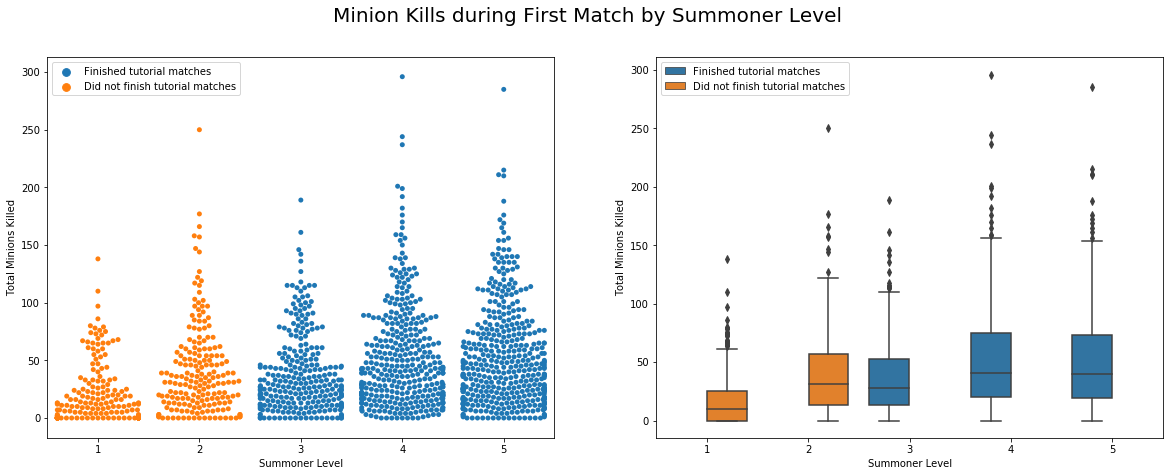

In [44]:
fig, ax = plt.subplots(ncols=2, figsize=(20,7))

ax[0] = sns.swarmplot(x='summoner_level', y='totalMinionsKilled', hue='low_level', data=df, ax=ax[0])
ax[0].set(xlabel="Summoner Level", ylabel="Total Minions Killed")
ax[0].legend_.set_title("")

ax[1] = sns.boxplot(x='summoner_level', y='totalMinionsKilled', hue='low_level', data=df, ax=ax[1])
ax[1].set(xlabel="Summoner Level", ylabel="Total Minions Killed")
ax[1].legend_.set_title("")

plt.suptitle("Minion Kills during First Match by Summoner Level", fontsize=20)

# to save plot to file:
# ax = ax.get_figure()
# ax.savefig("./docs/minions_swarm_high_res.png", dpi=750, bbox_inches="tight")

We see the trend that players reaching higher levels got more minion kills in their first match. But another striking point can be seen in the box plot; **there are a lot of outliers.** 

Because League of Legends is free to play (only requires an email address), a lot of experienced players will make new accounts to play in low level matches just for fun (or whatever other reason). These sort of new accounts made by experienced players are called smurf accounts. Their data doesn't represent the kind of truly new players that we want to make predictions on, so taking these outliers out of the dataset may be a good way to control for smurf accounts. For now they will be left in though.

**Average total damage dealt**

In [7]:
print("Average gold earned by players level 1-2 = {:.0f}".format(np.mean(low_level['totalDamageDealt'])))
print("Average gold earned by players level 3-5 = {:.0f}".format(np.mean(high_level['totalDamageDealt'])))
print("Two-sided t-test (low_level wins vs high_level wins): p-value = {}".format(stats.ttest_ind(low_level['totalDamageDealt'],high_level['totalDamageDealt'])[1]))

Average gold earned by players level 1-2 = 28614
Average gold earned by players level 3-5 = 46486
Two-sided t-test (low_level wins vs high_level wins): p-value = 6.395087207824394e-12


This is the biggest divergence we've seen yet! Of course the same logic applies as with minions killed and gold earned; doing damage is a successful behavior in the game. Let's plot this as we did with minion kills to better see how the two groups of players separate here.

Text(0.5,0.98,'Total Damage Dealt during First Match by Summoner Level')

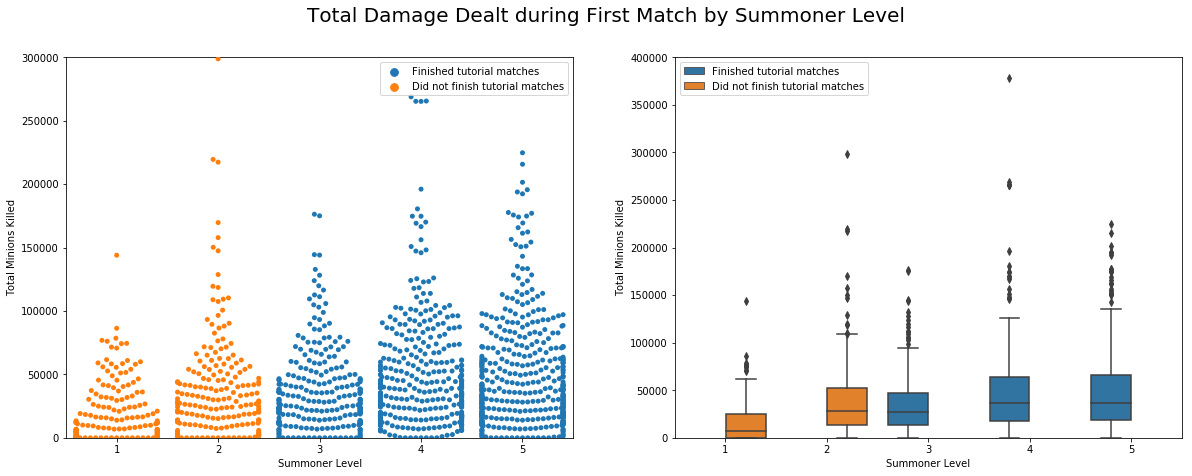

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(20,7))

ax[0] = sns.swarmplot(x='summoner_level', y='totalDamageDealt', hue='low_level', data=df, ax=ax[0])
ax[0].set(xlabel="Summoner Level", ylabel="Total Minions Killed")
ax[0].set_ylim(0,300000)
ax[0].legend_.set_title("")

ax[1] = sns.boxplot(x='summoner_level', y='totalDamageDealt', hue='low_level', data=df, ax=ax[1])
ax[1].set(xlabel="Summoner Level", ylabel="Total Minions Killed")
ax[1].set_ylim(0,400000)
ax[1].legend_.set_title("")

plt.suptitle("Total Damage Dealt during First Match by Summoner Level", fontsize=20)

Now that we've seen how are data separates around different summoner levels let's try to build some prediction models in the next notebook!

***

<div align="right">
    <a href="#toc">back to top</a>
</div>

## End of Part 2

### In the <a href="https://nbviewer.jupyter.org/github/dskarbrevik/League-of-Legends-Churn-Prediction/blob/master/LoL%20Churn%20Predictor%20%5BPart%203%20-%20Data%20Modeling%5D.ipynb">next notebook</a>, we'll get our data ready for modeling and test out a few models to finally see if we can make our "churn" predictions as we set out to do from the start!